### Importing 

In [1]:
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series / stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Prophet (make sure package named 'prophet' is installed)
try:
    from prophet import Prophet
except Exception:
    # older name
    from fbprophet import Prophet

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


### Load data 

In [2]:

# Load data (paths preserved from your notebook)

sales_filepath = 'Pizza_Sale - pizza_sales.csv'
ingredients_filepath = 'Pizza_ingredients - Pizza_ingredients.csv'

if not os.path.exists(sales_filepath):
    raise FileNotFoundError(f"Sales file not found: {sales_filepath}")
if not os.path.exists(ingredients_filepath):
    raise FileNotFoundError(f"Ingredients file not found: {ingredients_filepath}")

sales = pd.read_csv(sales_filepath)
ingredients = pd.read_csv(ingredients_filepath)

print('Loaded:', sales_filepath, '->', sales.shape)
print('Loaded:', ingredients_filepath, '->', ingredients.shape)


Loaded: Pizza_Sale - pizza_sales.csv -> (48620, 12)
Loaded: Pizza_ingredients - Pizza_ingredients.csv -> (518, 4)


In [3]:
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [6]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [7]:
# detect column names
expected_cols = {
    'pizza_type': [c for c in sales.columns if 'pizza' in c or 'product' in c or 'item' in c],
    'quantity_sold': [c for c in sales.columns if 'quantity' in c or 'qty' in c or 'sold' in c],
    'price': [c for c in sales.columns if 'price' in c or 'cost' in c],
}

pizza_col = expected_cols['pizza_type'][0] if expected_cols['pizza_type'] else None
qty_col   = expected_cols['quantity_sold'][0] if expected_cols['quantity_sold'] else None
price_col = expected_cols['price'][0] if expected_cols['price'] else None


In [8]:
# Handle missing values in Sales and Ingredients datasets

# --- Sales dataset ---
print("Missing values in Sales before treatment:")
print(sales.isna().sum())

# Strategy:
# - pizza_name_id, pizza_name, pizza_category, pizza_ingredients -> fill with 'Unknown'
# - total_price -> compute as quantity * unit_price if available, else 0

if 'pizza_name_id' in sales.columns:
    sales['pizza_name_id'] = sales['pizza_name_id'].fillna('Unknown')

if 'pizza_name' in sales.columns:
    sales['pizza_name'] = sales['pizza_name'].fillna('Unknown')

if 'pizza_category' in sales.columns:
    sales['pizza_category'] = sales['pizza_category'].fillna('Unknown')

if 'pizza_ingredients' in sales.columns:
    sales['pizza_ingredients'] = sales['pizza_ingredients'].fillna('Unknown')

if 'total_price' in sales.columns and 'unit_price' in sales.columns and qty_col:
    # fill missing total_price
    missing_total = sales['total_price'].isna()
    sales.loc[missing_total, 'total_price'] = (
        sales.loc[missing_total, 'unit_price'] * sales.loc[missing_total, qty_col]
    )
    # any still missing -> set to 0
    sales['total_price'] = sales['total_price'].fillna(0)

print("\nMissing values in Sales after treatment:")
print(sales.isna().sum())

# --- Ingredients dataset ---
print("\nMissing values in Ingredients before treatment:")
print(ingredients.isna().sum())

# Strategy:
# - Items_Qty_In_Grams -> fill with median (numerical column)
if 'Items_Qty_In_Grams' in ingredients.columns:
    median_val = ingredients['Items_Qty_In_Grams'].median()
    ingredients['Items_Qty_In_Grams'] = ingredients['Items_Qty_In_Grams'].fillna(median_val)

# Just in case: fillna for text fields
for col in ['pizza_name_id', 'pizza_name', 'pizza_ingredients']:
    if col in ingredients.columns:
        ingredients[col] = ingredients[col].fillna('Unknown')

print("\nMissing values in Ingredients after treatment:")
print(ingredients.isna().sum())


Missing values in Sales before treatment:
pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

Missing values in Sales after treatment:
pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

Missing values in Ingredients before treatment:
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

Missing values in Ingredients after treatment:
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64


In [9]:
# Convert 'order_date' to datetime with dayfirst=True to match DD-MM-YYYY format
sales['order_date'] = pd.to_datetime(sales['order_date'],format='mixed')
sales['order_time'] = pd.to_datetime(sales['order_time'],format='%H:%M:%S').dt.time

# Optional: Combine into one datetime column
sales['order_datetime'] = pd.to_datetime(
    sales['order_date'].astype(str) + " " + sales['order_time'].astype(str),
    errors='coerce'
)


In [10]:
print(sales[['order_date','order_time']].head())
print(sales.dtypes)


  order_date order_time
0 2015-01-01   11:38:36
1 2015-01-01   11:57:40
2 2015-01-01   11:57:40
3 2015-01-01   11:57:40
4 2015-01-01   11:57:40
pizza_id                      int64
order_id                      int64
pizza_name_id                object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
order_datetime       datetime64[ns]
dtype: object


In [11]:
# Checking unique values in each column
sales.nunique()

pizza_id             48620
order_id             21350
pizza_name_id           92
quantity                 4
order_date             358
order_time           16382
unit_price              25
total_price             56
pizza_size               5
pizza_category           5
pizza_ingredients       33
pizza_name              33
order_datetime       21350
dtype: int64

### EDA 

Dataset Shape: (48620, 13)

Missing Values:
 pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
order_datetime       0
dtype: int64


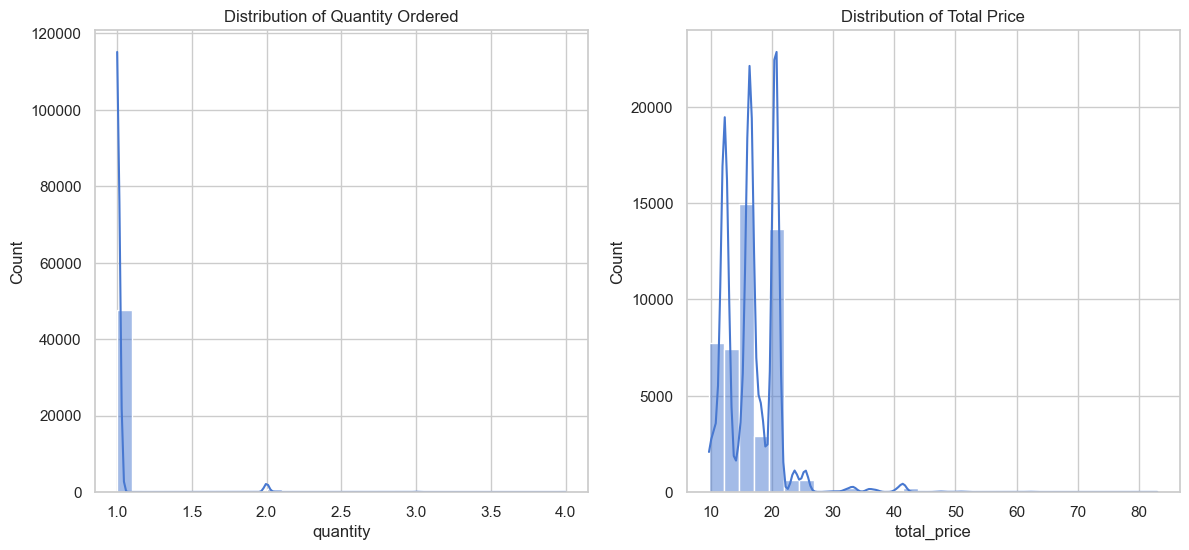

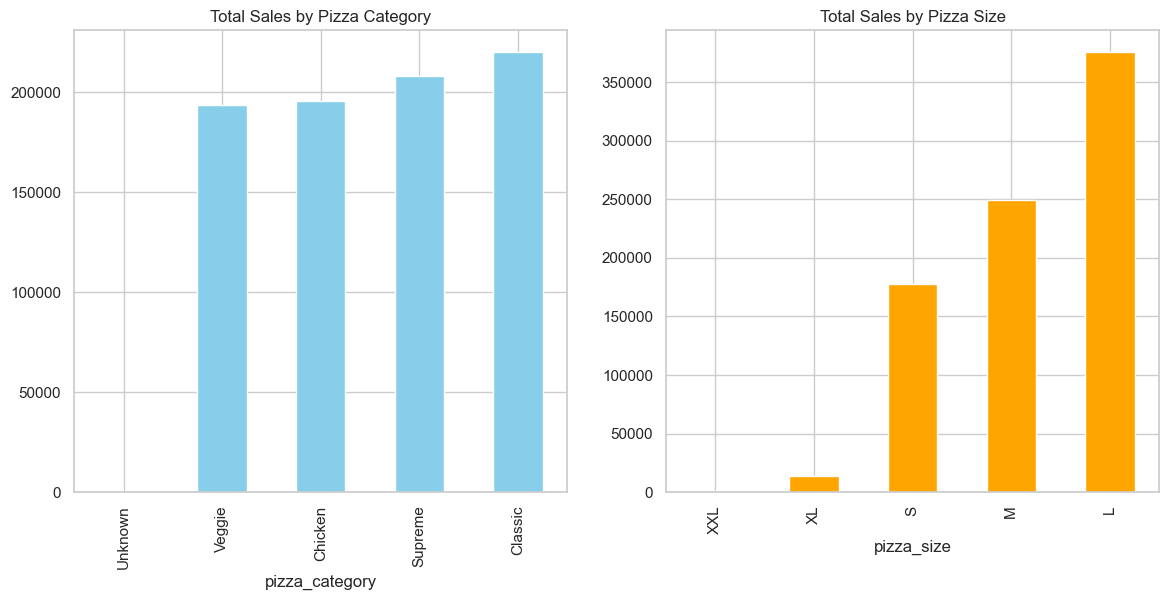

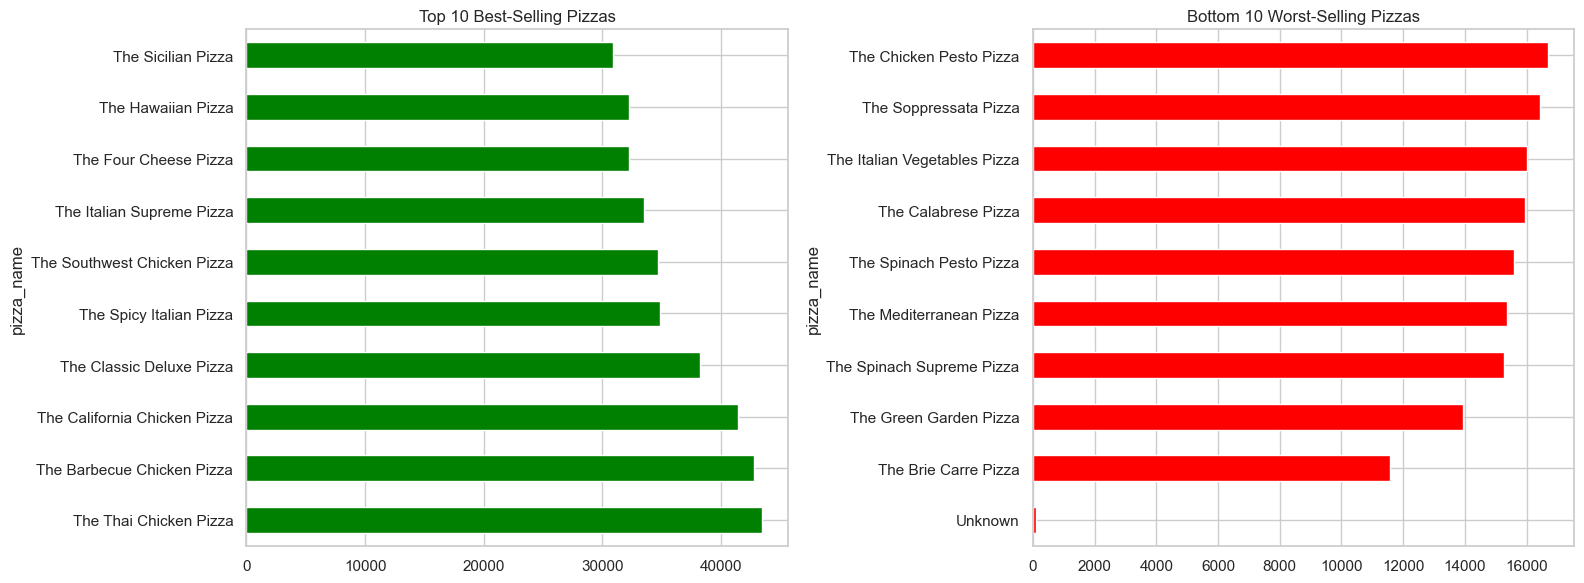

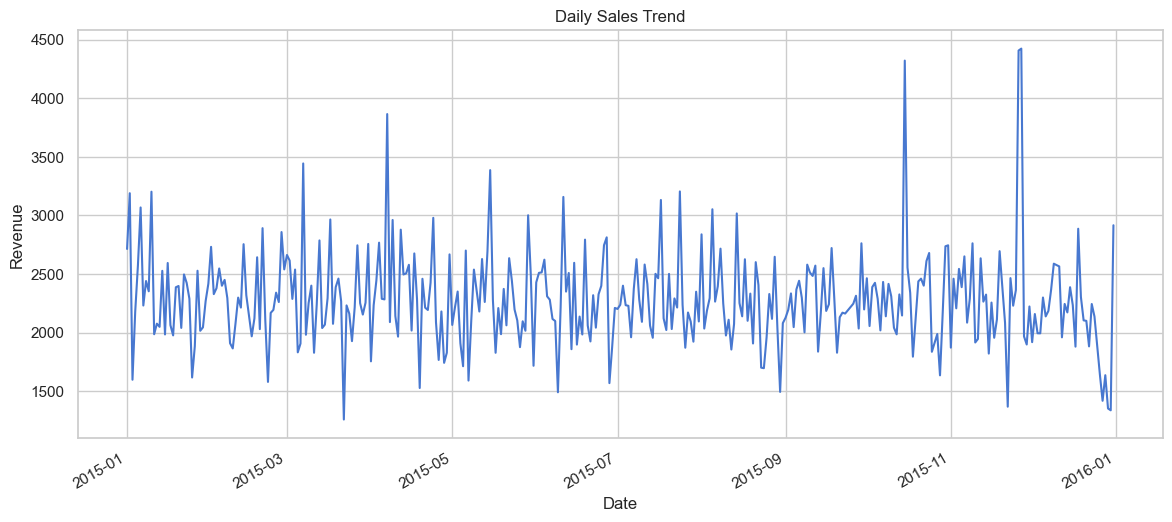

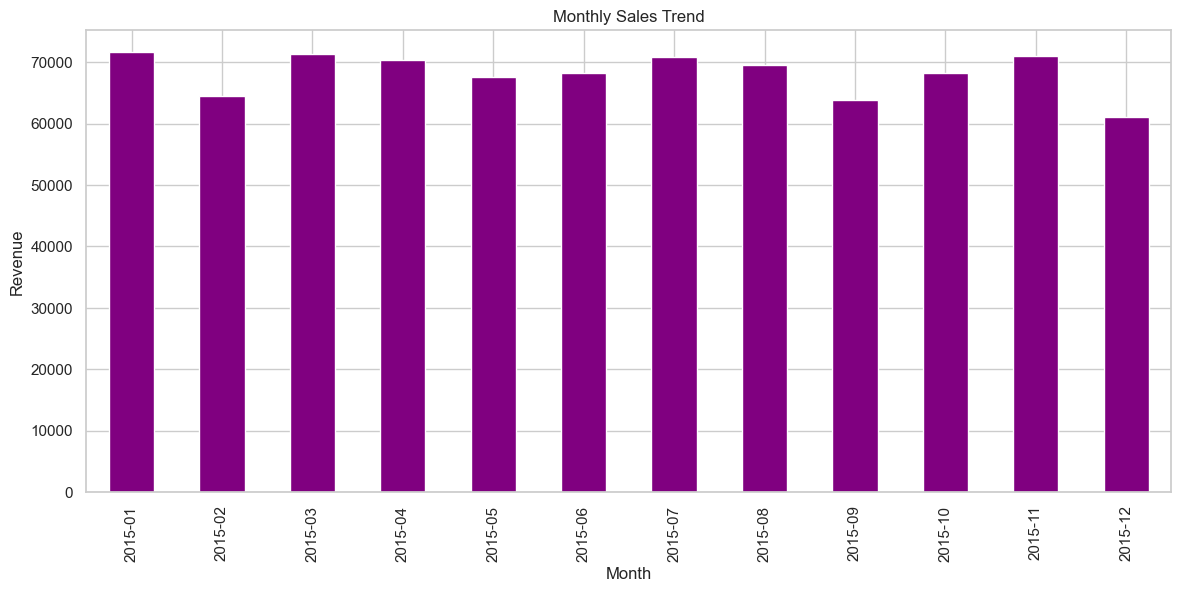

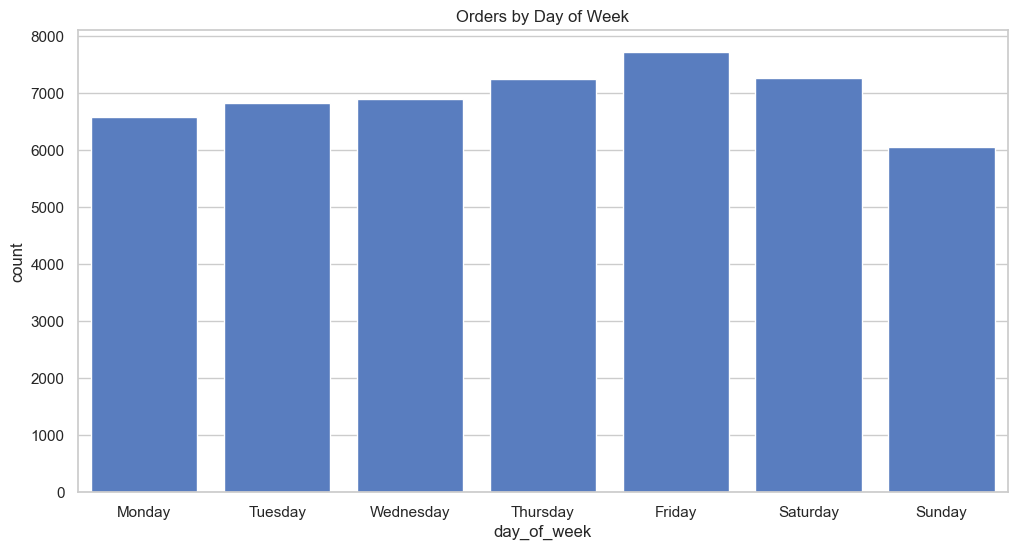

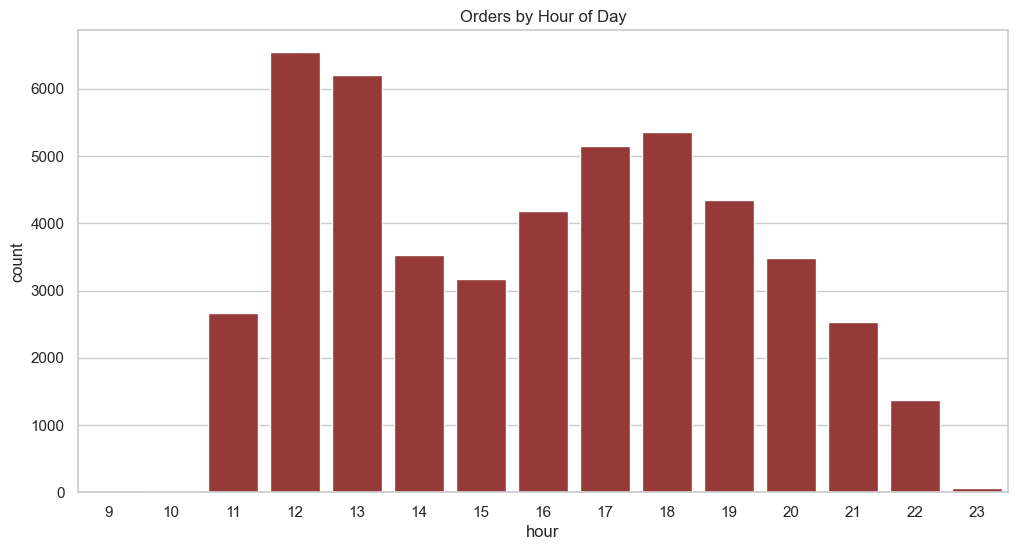

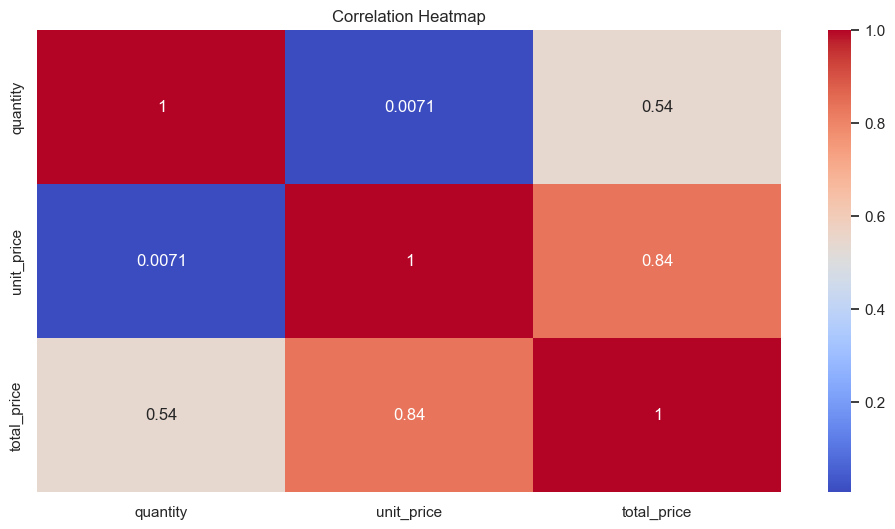

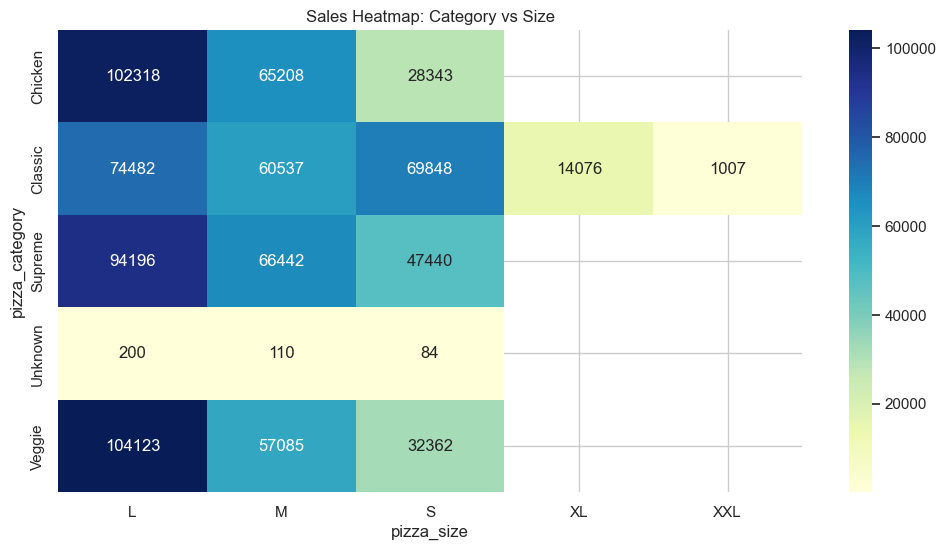

In [12]:
# Set style
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12,6)

# -----------------------
# 1) Basic Overview
# -----------------------
print("Dataset Shape:", sales.shape)
print("\nMissing Values:\n", sales.isna().sum())

# -----------------------
# 2) Distribution of Quantities & Prices
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.histplot(sales["quantity"], kde=True, ax=axes[0], bins=30)
axes[0].set_title("Distribution of Quantity Ordered")

sns.histplot(sales["total_price"], kde=True, ax=axes[1], bins=30)
axes[1].set_title("Distribution of Total Price")

plt.show()

# -----------------------
# 3) Sales by Pizza Category & Size
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sales.groupby("pizza_category")["total_price"].sum().sort_values().plot(
    kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Total Sales by Pizza Category")

sales.groupby("pizza_size")["total_price"].sum().sort_values().plot(
    kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Total Sales by Pizza Size")

plt.show()

# -----------------------
# 4) Top & Bottom Pizzas by Sales
# -----------------------
top_pizzas = sales.groupby("pizza_name")["total_price"].sum().sort_values(ascending=False).head(10)
bottom_pizzas = sales.groupby("pizza_name")["total_price"].sum().sort_values(ascending=True).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_pizzas.plot(kind="barh", ax=axes[0], color="green")
axes[0].set_title("Top 10 Best-Selling Pizzas")

bottom_pizzas.plot(kind="barh", ax=axes[1], color="red")
axes[1].set_title("Bottom 10 Worst-Selling Pizzas")

plt.tight_layout()
plt.show()

# -----------------------
# 5) Time Series Analysis
# -----------------------
# Daily sales
daily_sales = sales.groupby("order_date")["total_price"].sum()

plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title("Daily Sales Trend")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.show()

# Monthly sales
monthly_sales = sales.groupby(sales["order_date"].dt.to_period("M"))["total_price"].sum()

monthly_sales.plot(kind="bar", figsize=(14,6), color="purple")
plt.title("Monthly Sales Trend")
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.show()

# -----------------------
# 6) Day of Week & Hourly Trends
# -----------------------
sales["day_of_week"] = sales["order_date"].dt.day_name()
sales["hour"] = sales["order_datetime"].dt.hour

# Orders by day of week
sns.countplot(data=sales, x="day_of_week", order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Orders by Day of Week")
plt.show()

# Orders by hour
sns.countplot(data=sales, x="hour", color="brown")
plt.title("Orders by Hour of Day")
plt.show()

# -----------------------
# 7) Correlation Analysis
# -----------------------
corr = sales[["quantity","unit_price","total_price"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# -----------------------
# 8) Category vs Size Heatmap
# -----------------------
pivot = sales.pivot_table(values="total_price", index="pizza_category", columns="pizza_size", aggfunc="sum")

sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales Heatmap: Category vs Size")
plt.show()


### Outlier Handling 

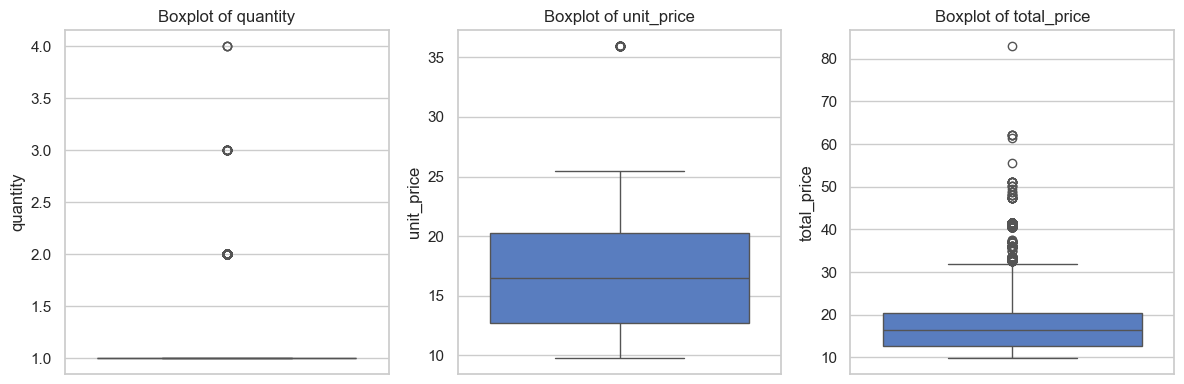

Outliers in quantity: 927
Outliers handled. Cleaned data sample:


,quantity,unit_price,total_price
count,48620.0,48620.000000,48620.000000
mean,1.0,16.491569,16.739523
std,0.0,3.609575,4.039728
min,1.0,9.750000,9.750000
25%,1.0,12.750000,12.750000
50%,1.0,16.500000,16.500000
75%,1.0,20.250000,20.500000
max,1.0,31.500000,32.125000


In [13]:
# --- Outlier Detection and Handling ---


# Columns where outliers make sense to check
numeric_cols = ["quantity", "unit_price", "total_price"]

# 1. Visual check with boxplots
plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=sales[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# 2. IQR method for outlier detection
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

# Example: check outliers in quantity
outliers_quantity = detect_outliers_iqr(sales, "quantity")
print("Outliers in quantity:", len(outliers_quantity))

# 3. Remove or cap outliers (here we cap them at lower/upper bound)
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower,
                np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping for numeric columns
for col in numeric_cols:
    sales = cap_outliers(sales, col)

print("Outliers handled. Cleaned data sample:")
display(sales[numeric_cols].describe())


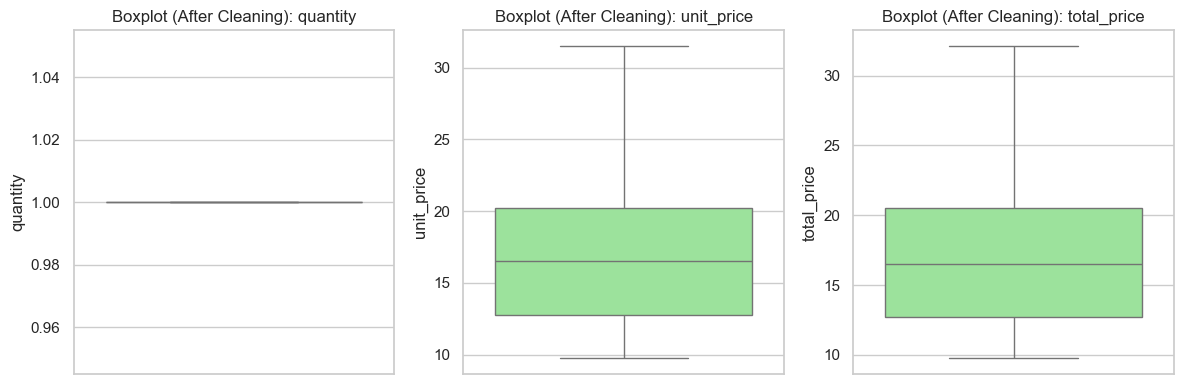

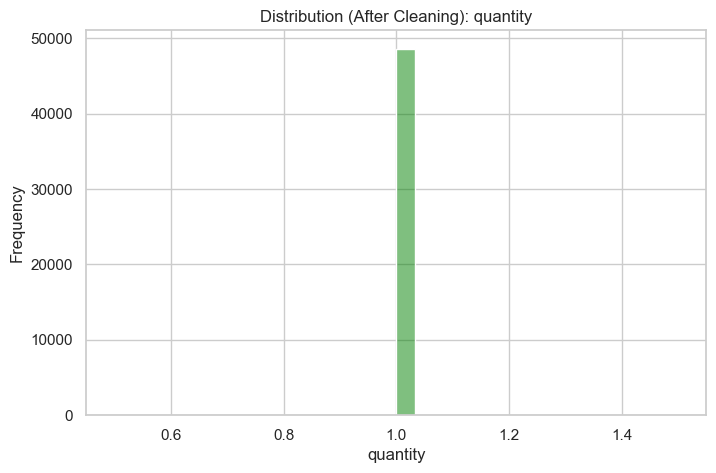

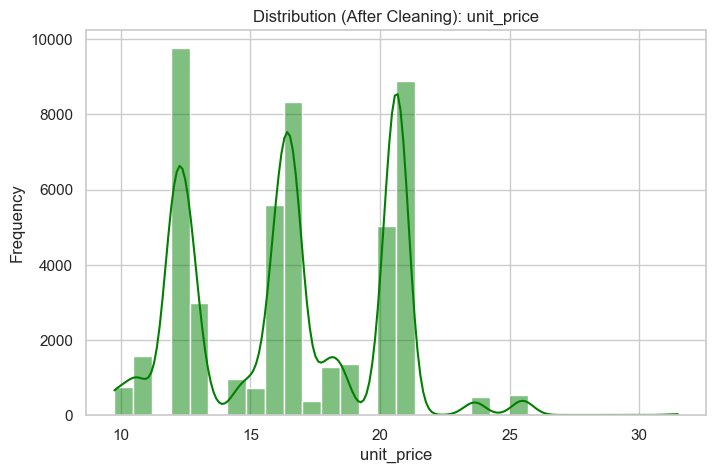

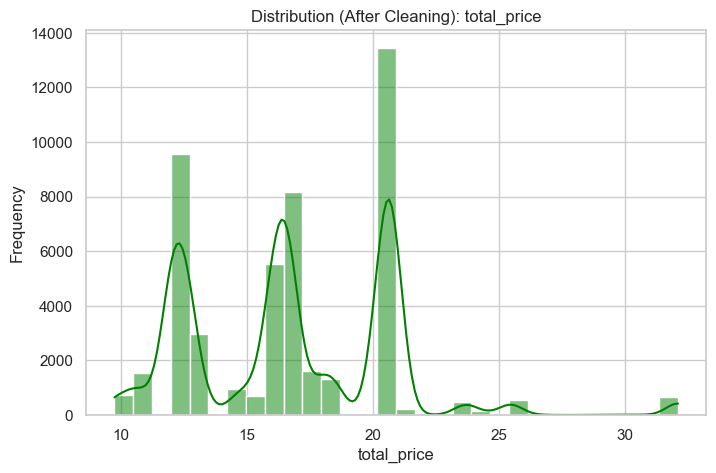

In [14]:
# --- Visualization After Outlier Handling ---

# Boxplots of cleaned numeric columns
plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=sales[col], color="lightgreen")
    plt.title(f"Boxplot (After Cleaning): {col}")
plt.tight_layout()
plt.show()

# Histograms of cleaned numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(sales[col], kde=True, bins=30, color="green")
    plt.title(f"Distribution (After Cleaning): {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### Feature Engineering 

In [15]:
# --- Aggregate daily sales ---
# We forecast revenue (total_price) per day
daily_sales = sales.groupby("order_date")["total_price"].sum().reset_index()
daily_sales = daily_sales.sort_values("order_date").reset_index(drop=True)

# --- Create time-based features ---
daily_sales["day"] = daily_sales["order_date"].dt.day
daily_sales["month"] = daily_sales["order_date"].dt.month
daily_sales["year"] = daily_sales["order_date"].dt.year
daily_sales["weekday"] = daily_sales["order_date"].dt.weekday  # 0=Monday, 6=Sunday
daily_sales["is_weekend"] = daily_sales["weekday"].isin([5,6]).astype(int)
daily_sales["weekofyear"] = daily_sales["order_date"].dt.isocalendar().week.astype(int)

# --- Lag features (previous sales values) ---
daily_sales["lag_1"] = daily_sales["total_price"].shift(1)   # yesterday
daily_sales["lag_7"] = daily_sales["total_price"].shift(7)   # same day last week
daily_sales["lag_30"] = daily_sales["total_price"].shift(30) # same day last month

# --- Rolling mean features (moving averages) ---
daily_sales["rolling_7_mean"] = daily_sales["total_price"].shift(1).rolling(7).mean()
daily_sales["rolling_30_mean"] = daily_sales["total_price"].shift(1).rolling(30).mean()

# --- Expanding mean (long-term average up to that date) ---
daily_sales["expanding_mean"] = daily_sales["total_price"].expanding(2).mean()

# --- Drop missing rows caused by shifting/rolling ---
daily_sales = daily_sales.dropna().reset_index(drop=True)

print("Feature Engineering complete! Dataset shape:", daily_sales.shape)
display(daily_sales.head(10))


Feature Engineering complete! Dataset shape: (328, 14)


,order_date,total_price,day,month,year,weekday,is_weekend,weekofyear,lag_1,lag_7,lag_30,rolling_7_mean,rolling_30_mean,expanding_mean
0,2015-01-31,2401.100,31,1,2015,5,1,5,2270.300,2289.250,2713.850,2082.957143,2296.770000,2300.135484
1,2015-02-01,2692.400,1,2,2015,6,1,5,2401.100,1617.550,3189.200,2098.935714,2286.345000,2312.393750
2,2015-02-02,2328.600,2,2,2015,0,0,6,2692.400,1880.575,1598.550,2252.485714,2269.785000,2312.884848
3,2015-02-03,2379.050,3,2,2015,1,0,6,2328.600,2506.475,2176.850,2316.489286,2294.120000,2314.830882
4,2015-02-04,2495.500,4,2,2015,2,0,6,2379.050,2005.750,2565.700,2298.285714,2300.860000,2319.992857
5,2015-02-05,2389.450,5,2,2015,3,0,6,2495.500,2010.800,3054.000,2368.250000,2298.520000,2321.922222
6,2015-02-06,2441.575,6,2,2015,4,0,6,2389.450,2270.300,2220.875,2422.342857,2276.368333,2325.156081
7,2015-02-07,2266.675,7,2,2015,5,1,6,2441.575,2401.100,2426.300,2446.810714,2283.725000,2323.617105
8,2015-02-08,1891.025,8,2,2015,6,1,6,2266.675,2692.400,2351.975,2427.607143,2278.404167,2312.525000
9,2015-02-09,1864.175,9,2,2015,0,0,7,1891.025,2328.600,3192.400,2313.125000,2263.039167,2301.316250


In [16]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_date       328 non-null    datetime64[ns]
 1   total_price      328 non-null    float64       
 2   day              328 non-null    int32         
 3   month            328 non-null    int32         
 4   year             328 non-null    int32         
 5   weekday          328 non-null    int32         
 6   is_weekend       328 non-null    int32         
 7   weekofyear       328 non-null    int32         
 8   lag_1            328 non-null    float64       
 9   lag_7            328 non-null    float64       
 10  lag_30           328 non-null    float64       
 11  rolling_7_mean   328 non-null    float64       
 12  rolling_30_mean  328 non-null    float64       
 13  expanding_mean   328 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(6)

In [17]:
#   Prepare time series variables (safe) 

# Set horizon (test window). Keep consistent with earlier cells (28 used before).
horizon = 28

# Rebuild daily_sales if it isn't in memory
if 'daily_sales' not in globals():
    # expects 'sales' DataFrame to exist
    if 'sales' not in globals():
        raise NameError("sales DataFrame not found. Load your sales CSV into 'sales' before running this cell.")
    daily_sales = sales.groupby("order_date")["total_price"].sum().reset_index().sort_values("order_date").reset_index(drop=True)

# Ensure order_date is datetime
if not np.issubdtype(daily_sales["order_date"].dtype, np.datetime64):
    daily_sales["order_date"] = pd.to_datetime(daily_sales["order_date"], errors="coerce")
    daily_sales = daily_sales.dropna(subset=["order_date"]).sort_values("order_date").reset_index(drop=True)

# Build daily series (fill missing days with 0)
series = daily_sales.set_index("order_date")["total_price"].asfreq("D").fillna(0)

# Train/test split
if len(series) <= horizon:
    raise ValueError(f"Not enough data for the chosen horizon={horizon}. Series length = {len(series)}")
train_series = series.iloc[:-horizon]
test_series = series.iloc[-horizon:]

print("Prepared series:")
print(" - daily_sales rows:", daily_sales.shape[0])
print(" - series length:", len(series))
print(" - train_series length:", len(train_series))
print(" - test_series length:", len(test_series))


Prepared series:
 - daily_sales rows: 328
 - series length: 335
 - train_series length: 307
 - test_series length: 28


RandomForest MAPE: 26.57%


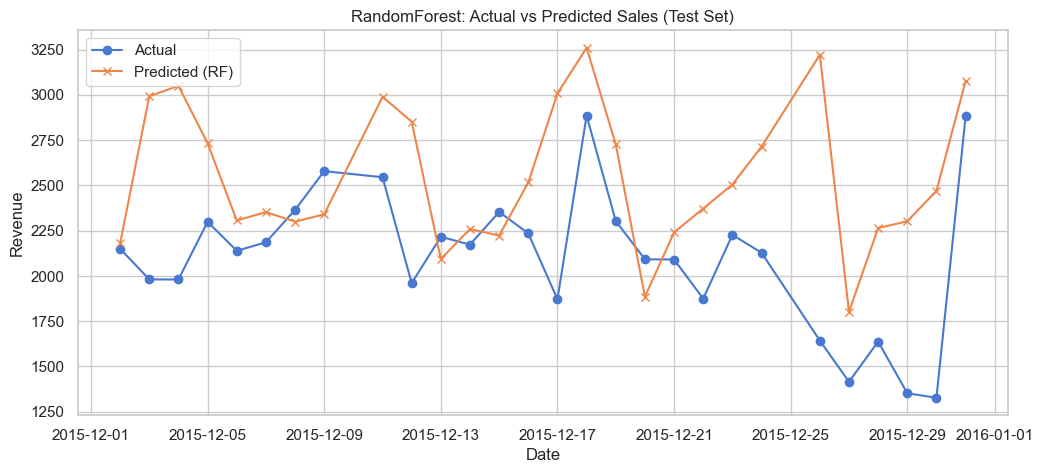

In [18]:
#  RandomForest

from sklearn.ensemble import RandomForestRegressor

# --- Define target and features ---
target = "total_price"
features = [col for col in daily_sales.columns if col not in ["order_date", "total_price"]]

# --- Train/Test Split ---
horizon = 28  # last 28 days for testing
train = daily_sales.iloc[:-horizon]
test = daily_sales.iloc[-horizon:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# --- Train RandomForest Model ---
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Predictions ---
y_pred_rf = rf.predict(X_test)

# --- Evaluation Metric: MAPE ---
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

mape_rf = mape(y_test, y_pred_rf)
print("RandomForest MAPE: {:.2f}%".format(mape_rf))

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(12,5))
plt.plot(test["order_date"], y_test, label="Actual", marker="o")
plt.plot(test["order_date"], y_pred_rf, label="Predicted (RF)", marker="x")
plt.title("RandomForest: Actual vs Predicted Sales (Test Set)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()


SARIMA MAPE: 16.59%


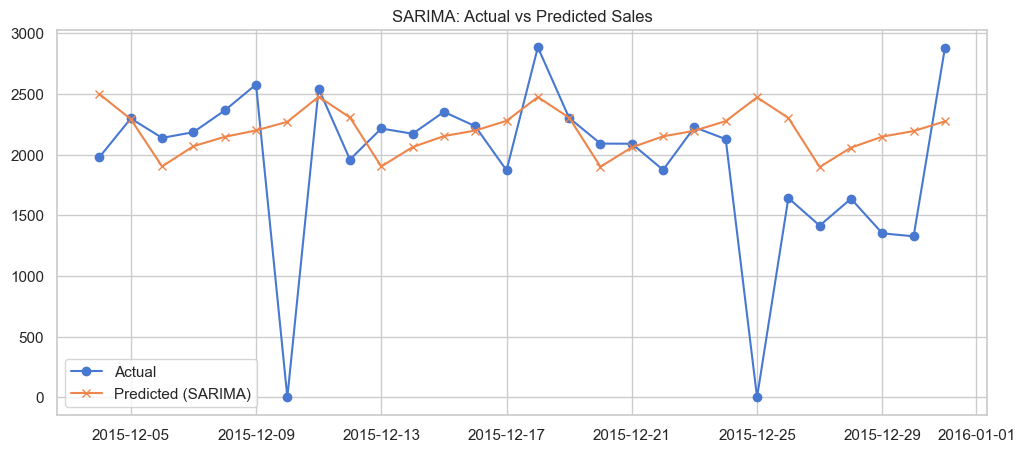

In [19]:
#  SARIMA

import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(
    train_series,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)

sarima_forecast = sarima_result.get_forecast(steps=horizon).predicted_mean

mape_sarima = mape(test_series.values, sarima_forecast.values)
print("SARIMA MAPE: {:.2f}%".format(mape_sarima))

plt.figure(figsize=(12,5))
plt.plot(test_series.index, test_series.values, label="Actual", marker="o")
plt.plot(test_series.index, sarima_forecast.values, label="Predicted (SARIMA)", marker="x")
plt.title("SARIMA: Actual vs Predicted Sales")
plt.legend()
plt.show()


ARIMA MAPE: 16.38%


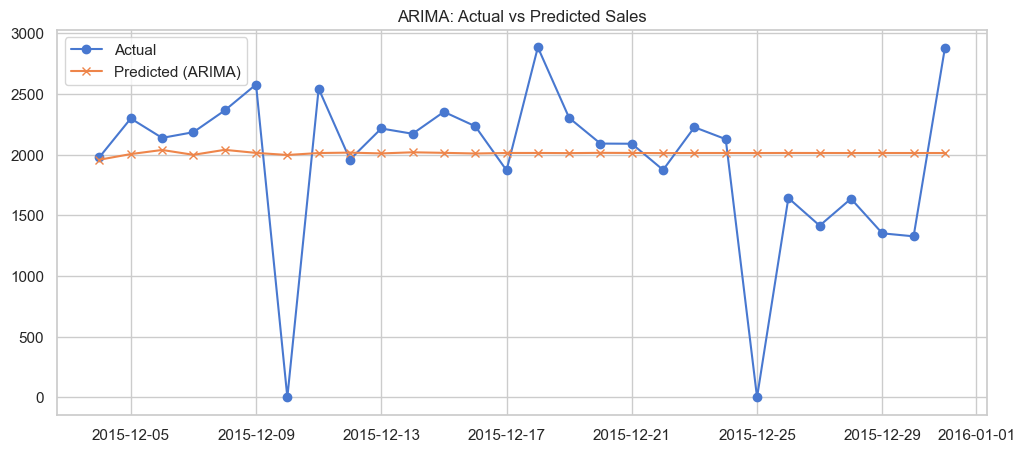

In [20]:
# ARIMA

from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model (no seasonality)
arima_model = ARIMA(train_series, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast next horizon days
arima_forecast = arima_result.forecast(steps=horizon)

# Evaluate
mape_arima = mape(test_series.values, arima_forecast.values)
print("ARIMA MAPE: {:.2f}%".format(mape_arima))

# Plot
plt.figure(figsize=(12,5))
plt.plot(test_series.index, test_series.values, label="Actual", marker="o")
plt.plot(test_series.index, arima_forecast.values, label="Predicted (ARIMA)", marker="x")
plt.title("ARIMA: Actual vs Predicted Sales")
plt.legend()
plt.show()


10:05:25 - cmdstanpy - INFO - Chain [1] start processing
10:05:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 16.38%


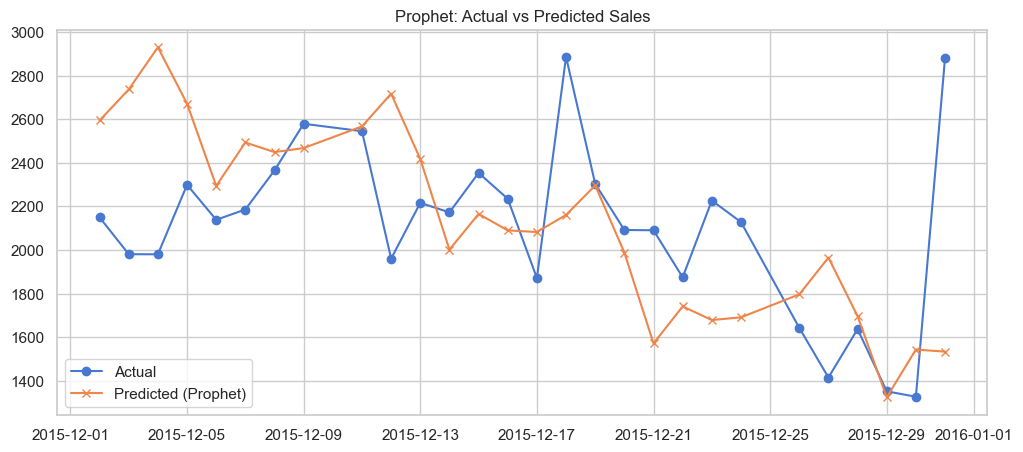

In [21]:
# Prophet


# Prepare data for Prophet (needs columns 'ds' and 'y')
prophet_df = daily_sales[["order_date","total_price"]].rename(columns={"order_date":"ds", "total_price":"y"})

# Train on train set only
prophet_train = prophet_df.iloc[:-horizon]
prophet_test = prophet_df.iloc[-horizon:]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(prophet_train)

# Forecast
future = model_prophet.make_future_dataframe(periods=horizon)
forecast = model_prophet.predict(future)

prophet_forecast = forecast.iloc[-horizon:]["yhat"].values

# Evaluate
mape_prophet = mape(prophet_test["y"].values, prophet_forecast)
print("Prophet MAPE: {:.2f}%".format(mape_prophet))

# Plot
plt.figure(figsize=(12,5))
plt.plot(prophet_test["ds"], prophet_test["y"].values, label="Actual", marker="o")
plt.plot(prophet_test["ds"], prophet_forecast, label="Predicted (Prophet)", marker="x")
plt.title("Prophet: Actual vs Predicted Sales")
plt.legend()
plt.show()





1/1 [==============================] - 0s 356ms/step
LSTM MAPE: 18.71%


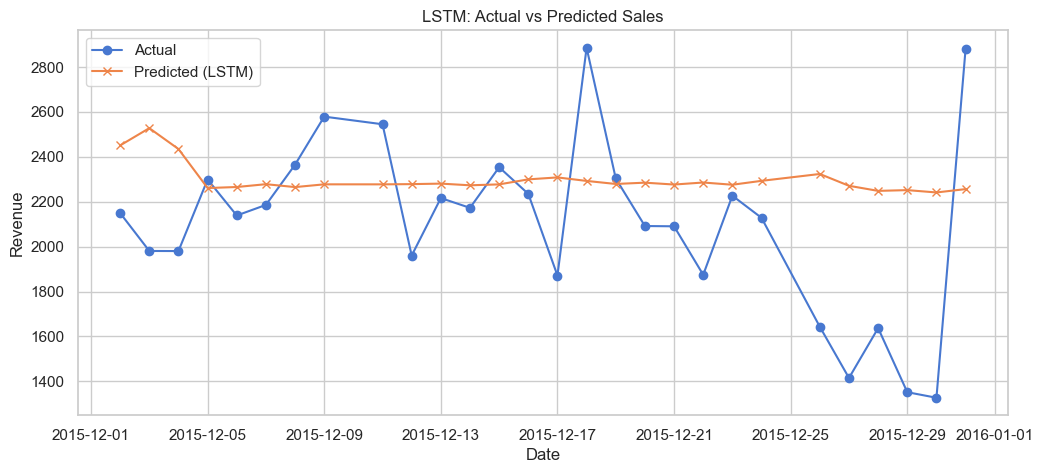

In [22]:
# LSTM (Neural Network)


# --- Prepare data for LSTM ---
series = daily_sales.set_index("order_date")["total_price"].values.reshape(-1,1)

# Scale data (LSTM works better on normalized data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_series = scaler.fit_transform(series)

# Function to create sequences
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 7  # use last 7 days to predict next day
X, y = create_sequences(scaled_series, SEQ_LENGTH)

# Split into train/test (same horizon as before)
X_train, X_test = X[:-horizon], X[-horizon:]
y_train, y_test = y[:-horizon], y[-horizon:]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

# --- Build LSTM model ---
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# --- Train ---
history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# --- Predict ---
y_pred_scaled = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_scaled)

# Inverse transform actuals
y_test_actual = scaler.inverse_transform(y_test)

# --- Evaluate ---
mape_lstm = mape(y_test_actual.flatten(), y_pred_lstm.flatten())
print("LSTM MAPE: {:.2f}%".format(mape_lstm))

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(daily_sales["order_date"].iloc[-horizon:], y_test_actual.flatten(), label="Actual", marker="o")
plt.plot(daily_sales["order_date"].iloc[-horizon:], y_pred_lstm.flatten(), label="Predicted (LSTM)", marker="x")
plt.title("LSTM: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()


### Model Evaluvation 

In [23]:
#  Model Evaluation & Comparison

# Collect MAPE scores from all models
results = {
    "ARIMA": mape_arima,
    "SARIMA": mape_sarima,
    "Prophet": mape_prophet,
    "RandomForest": mape_rf,
    "LSTM": mape_lstm
}

# Convert to DataFrame for nice display
results_df = pd.DataFrame(list(results.items()), columns=["Model", "MAPE (%)"]).sort_values("MAPE (%)")

print("Model Evaluation Results:")
display(results_df)

# Find best model
best_model_name = results_df.iloc[0]["Model"]
best_model_mape = results_df.iloc[0]["MAPE (%)"]

print(f" Best Model: {best_model_name} with MAPE = {best_model_mape:.2f}%")


Model Evaluation Results:


,Model,MAPE (%)
2,Prophet,16.380221
0,ARIMA,16.381112
1,SARIMA,16.593316
4,LSTM,18.711074
3,RandomForest,26.565081


 Best Model: Prophet with MAPE = 16.38%


10:05:39 - cmdstanpy - INFO - Chain [1] start processing
10:05:39 - cmdstanpy - INFO - Chain [1] done processing


Next 7 Days Forecast (Revenue):


,ds,yhat,yhat_lower,yhat_upper
328,2016-01-01,2274.740978,1825.834320,2719.683297
329,2016-01-02,2054.657434,1575.108995,2521.331136
330,2016-01-03,1758.551465,1295.549303,2199.774505
331,2016-01-04,2011.266827,1554.316566,2498.211361
332,2016-01-05,2047.061448,1607.636607,2504.023011
333,2016-01-06,2151.605243,1677.641425,2618.032917
334,2016-01-07,2352.593499,1916.025140,2796.668543


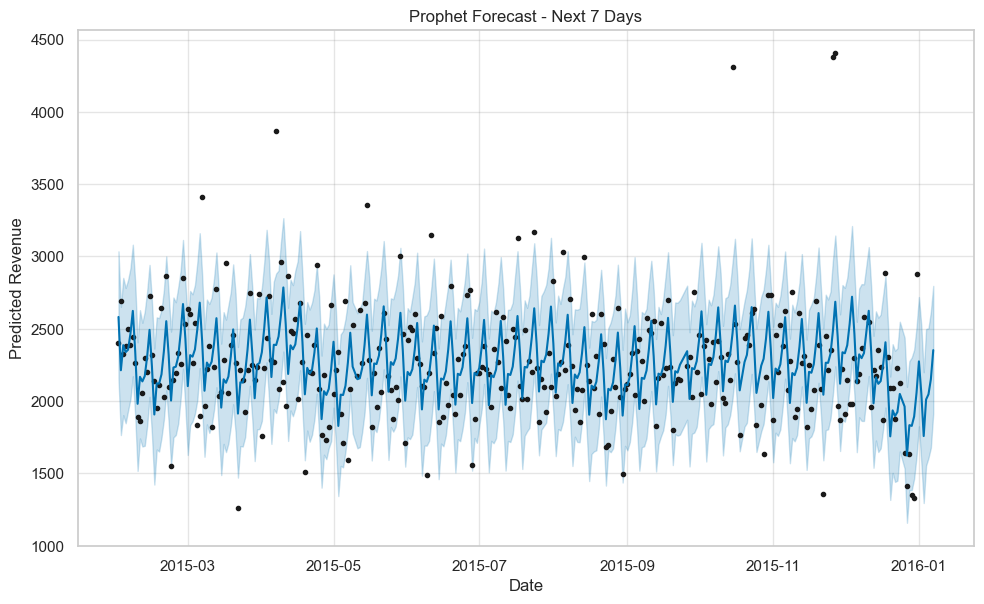

In [24]:
# Final Forecasting with Best Model (Prophet)


# Prepare full dataset for Prophet
prophet_df = daily_sales[["order_date","total_price"]].rename(columns={"order_date":"ds", "total_price":"y"})

# Train on full dataset
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(prophet_df)

# Forecast next 7 days
future = model_prophet.make_future_dataframe(periods=7)
forecast = model_prophet.predict(future)

# Extract only next 7 days
future_forecast = forecast.tail(7)[["ds","yhat","yhat_lower","yhat_upper"]]

print("Next 7 Days Forecast (Revenue):")
display(future_forecast)

# Plot forecast
model_prophet.plot(forecast)
plt.title("Prophet Forecast - Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Revenue")
plt.show()


In [25]:
# Step 7: Pizza-wise Forecasting for Next 7 Days (Fixed for 'sales' dataframe)

# Ensure datetime
sales['order_date'] = pd.to_datetime(sales['order_date'])

# 1. Aggregate sales by date and pizza name
pizza_groups = sales.groupby(['order_date', 'pizza_name'])['quantity'].sum().reset_index()

# 2. Dictionaries to store forecasts
pizza_forecasts = {}
future_sales = {}

# 3. Loop through each pizza type and build Prophet model
for pizza in pizza_groups['pizza_name'].unique():
    pizza_data = pizza_groups[pizza_groups['pizza_name'] == pizza][['order_date', 'quantity']].rename(
        columns={'order_date': 'ds', 'quantity': 'y'}
    )
    
    # Skip pizzas with <2 rows
    if pizza_data.shape[0] < 2:
        print(f"Skipping {pizza} (not enough data)")
        continue
    
    # Initialize Prophet
    model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(pizza_data)
    
    # Forecast next 7 days
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    
    # Save forecast
    pizza_forecasts[pizza] = forecast
    future_sales[pizza] = forecast[['ds', 'yhat']].tail(7)  # Next 7 days only

# 4. Combine forecasts into one dataframe
forecast_results = pd.concat(
    [df.assign(pizza_name=pizza) for pizza, df in future_sales.items()],
    ignore_index=True
)

# 5. Rename columns
forecast_results = forecast_results.rename(columns={'ds': 'date', 'yhat': 'predicted_quantity'})

# 6. Save to CSV
forecast_results.to_csv("pizza_forecast_next_7days.csv", index=False)

print(" Pizza-wise forecast saved to pizza_forecast_next_7days.csv")



10:05:40 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:41 - cmdstanpy - INFO - Chain [1] done processing
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:42 - cmdstanpy - INFO - Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:43 - cmdstanpy - INFO - Chain [1] start processing
10:05:43 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:44 - cmdstanpy - INFO - Chain [1] start processing
10:05:44 - cmdstanpy - INFO - Chain [1] done processing
10:05:45 - cmdstanpy - INFO - Chain [1] start processing
10:05:45 - cmdstanpy - INFO - Chain [1]

Skipping Unknown (not enough data)
 Pizza-wise forecast saved to pizza_forecast_next_7days.csv


### Ingredient Generation 

In [26]:
ingredients.nunique()


pizza_name_id         91
pizza_name            32
pizza_ingredients     64
Items_Qty_In_Grams    17
dtype: int64

In [27]:
# Final Step: Ingredient Purchase Order for Next 7 Days

# --- 1. Ensure pizza-level forecast is available ---
if 'forecast_results' not in globals():
    raise ValueError("No pizza-level forecast found. Please run pizza-wise forecasting before this cell.")

# Clean forecast dataframe
pizza_forecast_df = forecast_results.copy()
pizza_forecast_df = pizza_forecast_df.rename(columns={'pizza_name':'pizza','predicted_quantity':'forecasted_qty'})

print("Forecast data preview:")
display(pizza_forecast_df.head())

# --- 2. Load ingredients dataset ---
ingredients = pd.read_csv("Pizza_ingredients - Pizza_ingredients.csv")
ingredients.columns = ingredients.columns.str.strip().str.lower().str.replace(" ", "_")

# --- 3. Expand ingredients into rows ---
exploded = []
for _, row in ingredients.iterrows():
    pname = str(row.get("pizza_name","")).strip()
    ingr_text = str(row.get("pizza_ingredients","")).strip()
    if not ingr_text:
        continue
    # Split by comma/semicolon/pipe
    parts = [p.strip() for p in ingr_text.replace("|",",").replace(";",",").split(",") if p.strip()]
    qty = row.get("items_qty_in_grams", np.nan)

    # Distribute qty equally across ingredients if single number given
    if pd.notnull(qty) and isinstance(qty, (int, float)):
        per_ing = qty / len(parts) if len(parts) > 0 else 0
        qtys = [per_ing] * len(parts)
    else:
        qtys = [1.0] * len(parts)

    for ing_name, q in zip(parts, qtys):
        exploded.append({"pizza": pname, "ingredient": ing_name, "qty_per_pizza_grams": q})

ingredients_expanded = pd.DataFrame(exploded)

print("Expanded ingredients preview:")
display(ingredients_expanded.head())

# --- 4. Merge forecast with ingredients ---
merged = pizza_forecast_df.merge(ingredients_expanded, on="pizza", how="left")

merged["ingredient_required_grams"] = merged["forecasted_qty"] * merged["qty_per_pizza_grams"]

# --- 5. Final Purchase Order ---
purchase_order = merged.groupby("ingredient", as_index=False)["ingredient_required_grams"].sum()
purchase_order["ingredient_required_kg"] = purchase_order["ingredient_required_grams"] / 1000

purchase_order = purchase_order.sort_values("ingredient_required_grams", ascending=False).reset_index(drop=True)

print(" Final Purchase Order (Top 15 Ingredients):")
display(purchase_order.head(15))

# --- 6. Save to CSV ---
purchase_order.to_csv("purchase_order_next_7days.csv", index=False)
print("Saved: purchase_order_next_7days.csv")


Forecast data preview:


,date,forecasted_qty,pizza
0,2016-01-01,6.750667,The Barbecue Chicken Pizza
1,2016-01-02,5.858947,The Barbecue Chicken Pizza
2,2016-01-03,4.403419,The Barbecue Chicken Pizza
3,2016-01-04,4.986530,The Barbecue Chicken Pizza
4,2016-01-05,5.211154,The Barbecue Chicken Pizza


Expanded ingredients preview:


,pizza,ingredient,qty_per_pizza_grams
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0


 Final Purchase Order (Top 15 Ingredients):


,ingredient,ingredient_required_grams,ingredient_required_kg
0,Chicken,45569.767483,45.569767
1,Red Onions,40343.567804,40.343568
2,Tomatoes,25684.176013,25.684176
3,Capocollo,22920.898391,22.920898
4,Mushrooms,20934.493985,20.934494
5,Spinach,17493.946526,17.493947
6,Pepperoni,16865.418444,16.865418
7,Bacon,16192.116644,16.192117
8,Garlic,14413.721691,14.413722
9,Mozzarella Cheese,10601.312299,10.601312


Saved: purchase_order_next_7days.csv


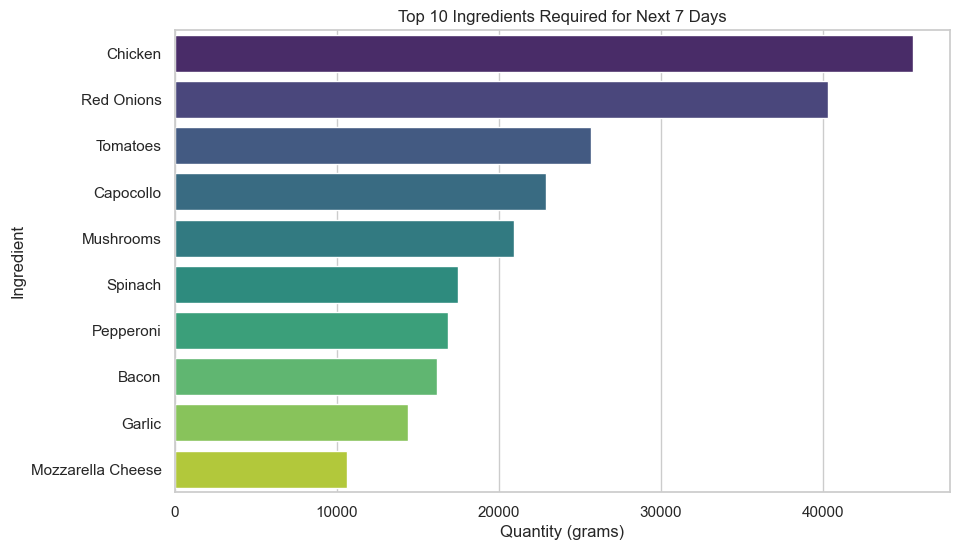

In [28]:
# Visualization: Top 10 Ingredients Required

top_n = 10
plt.figure(figsize=(10,6))
sns.barplot(
    data=purchase_order.head(top_n),
    x="ingredient_required_grams",
    y="ingredient",
    palette="viridis"
)
plt.title(f"Top {top_n} Ingredients Required for Next 7 Days")
plt.xlabel("Quantity (grams)")
plt.ylabel("Ingredient")
plt.show()
